# Use SimpleITK for 3D registration

### Prerequisiti

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from IPython.display import clear_output
from skimage.util import img_as_ubyte

In [2]:
def imshow_orthogonal_view(sitkImage, origin=None, title=None):
    """
    Display the orthogonal views of a 3D volume from the middle of the volume.

    Parameters
    ----------
    sitkImage : SimpleITK image
        Image to display.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    data = sitk.GetArrayFromImage(sitkImage)

    if origin is None:
        origin = np.array(data.shape) // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    data = img_as_ubyte(data / np.max(data))
    axes[0].imshow(data[origin[0], ::-1, ::-1], cmap="gray")
    axes[0].set_title("Axial")

    axes[1].imshow(data[::-1, origin[1], ::-1], cmap="gray")
    axes[1].set_title("Coronal")

    axes[2].imshow(data[::-1, ::-1, origin[2]], cmap="gray")
    axes[2].set_title("Sagittal")

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)


def overlay_slices(sitkImage0, sitkImage1, origin=None, title=None):
    """
    Overlay the orthogonal views of a two 3D volume from the middle of the volume.
    The two volumes must have the same shape. The first volume is displayed in red,
    the second in green.

    Parameters
    ----------
    sitkImage0 : SimpleITK image
        Image to display in red.
    sitkImage1 : SimpleITK image
        Image to display in green.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    vol0 = sitk.GetArrayFromImage(sitkImage0)
    vol1 = sitk.GetArrayFromImage(sitkImage1)

    if vol0.shape != vol1.shape:
        raise ValueError("The two volumes must have the same shape.")
    if (
        np.min(vol0) < 0 or np.min(vol1) < 0
    ):  # Remove negative values - Relevant for the noisy images
        vol0[vol0 < 0] = 0
        vol1[vol1 < 0] = 0
    if origin is None:
        origin = np.array(vol0.shape) // 2

    sh = vol0.shape
    R = img_as_ubyte(vol0 / np.max(vol0))
    G = img_as_ubyte(vol1 / np.max(vol1))

    vol_rgb = np.zeros(shape=(sh[0], sh[1], sh[2], 3), dtype=np.uint8)
    vol_rgb[:, :, :, 0] = R
    vol_rgb[:, :, :, 1] = G

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(vol_rgb[origin[0], ::-1, ::-1, :])
    axes[0].set_title("Axial")

    axes[1].imshow(vol_rgb[::-1, origin[1], ::-1, :])
    axes[1].set_title("Coronal")

    axes[2].imshow(vol_rgb[::-1, ::-1, origin[2], :])
    axes[2].set_title("Sagittal")

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

In [3]:
def composite2affine(composite_transform, result_center=None):
    """
    Combine all of the composite transformation's contents to form an equivalent affine transformation.
    Args:
        composite_transform (SimpleITK.CompositeTransform): Input composite transform which contains only
                                                            global transformations, possibly nested.
        result_center (tuple,list): The desired center parameter for the resulting affine transformation.
                                    If None, then set to [0,...]. This can be any arbitrary value, as it is
                                    possible to change the transform center without changing the transformation
                                    effect.
    Returns:
        SimpleITK.AffineTransform: Affine transformation that has the same effect as the input composite_transform.

    Source:
        https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/22_Transforms.ipynb
    """
    # Flatten the copy of the composite transform, so no nested composites.
    flattened_composite_transform = sitk.CompositeTransform(composite_transform)
    flattened_composite_transform.FlattenTransform()
    tx_dim = flattened_composite_transform.GetDimension()
    A = np.eye(tx_dim)
    c = np.zeros(tx_dim) if result_center is None else result_center
    t = np.zeros(tx_dim)
    for i in range(flattened_composite_transform.GetNumberOfTransforms() - 1, -1, -1):
        curr_tx = flattened_composite_transform.GetNthTransform(i).Downcast()
        # The TranslationTransform interface is different from other
        # global transformations.
        if curr_tx.GetTransformEnum() == sitk.sitkTranslation:
            A_curr = np.eye(tx_dim)
            t_curr = np.asarray(curr_tx.GetOffset())
            c_curr = np.zeros(tx_dim)
        else:
            A_curr = np.asarray(curr_tx.GetMatrix()).reshape(tx_dim, tx_dim)
            c_curr = np.asarray(curr_tx.GetCenter())
            # Some global transformations do not have a translation
            # (e.g. ScaleTransform, VersorTransform)
            get_translation = getattr(curr_tx, "GetTranslation", None)
            if get_translation is not None:
                t_curr = np.asarray(get_translation())
            else:
                t_curr = np.zeros(tx_dim)
        A = np.dot(A_curr, A)
        t = np.dot(A_curr, t + c - c_curr) + t_curr + c_curr - c

    return sitk.AffineTransform(A.flatten(), t, c)

In [4]:
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []


# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()


# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, "r")
    plt.plot(
        multires_iterations,
        [metric_values[index] for index in multires_iterations],
        "b*",
    )
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.show()


# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))


def command_iteration(method):
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():10.5f} "
        + f": {method.GetOptimizerPosition()}"
    )

## Advanced 3D registration


- Loading and 3D image and ortho view visualization
- Create and apply affine matrix transformation
- Registration of a moving image to a fixed image
- Convert the transformation to a homogeneous matrix
- Store and load the transformation matrix
- Change the rotation center to the center of the image
- Generate a series of rotated 3D images
- Combining a series of affine matrices


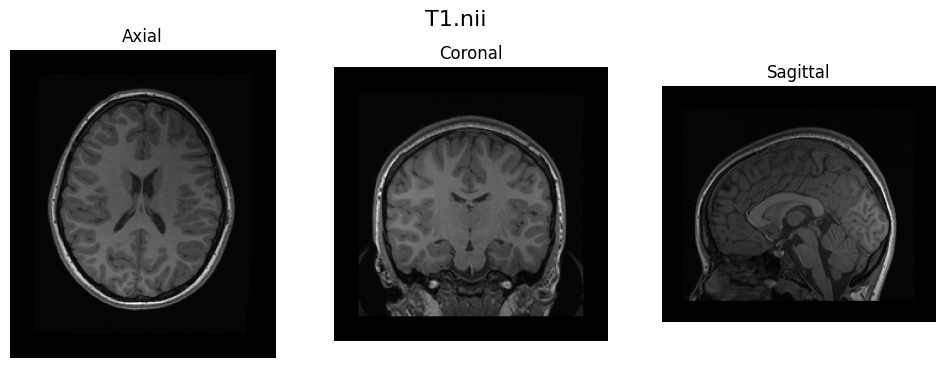

In [5]:
# Loading and 3D image and ortho view visualization
dir_in = "data/"

vol_sitk = sitk.ReadImage(dir_in + "ImgT1.nii")


# Display the volume

imshow_orthogonal_view(vol_sitk, title="T1.nii")

In [10]:
def rotation_matrix(pitch, roll, yaw):
    """
    Returns the rotation matrix for given roll, pitch, and yaw angles.
    """
    cos_pitch = np.cos(pitch)
    sin_pitch = np.sin(pitch)
    cos_roll = np.cos(roll)
    sin_roll = np.sin(roll)
    cos_yaw = np.cos(yaw)
    sin_yaw = np.sin(yaw)

    # Define the rotation matrix for pitch, roll, and yaw
    R_pitch = np.array(
        [[1, 0, 0], [0, cos_pitch, -sin_pitch], [0, sin_pitch, cos_pitch]],
    )

    R_roll = np.array([[cos_roll, 0, sin_roll], [0, 1, 0], [-sin_roll, 0, cos_roll]])

    R_yaw = np.array([[cos_yaw, -sin_yaw, 0], [sin_yaw, cos_yaw, 0], [0, 0, 1]])

    # Combine the rotation matrices to obtain the final rotation matrix
    rotation_matrix = np.dot(R_yaw, np.dot(R_pitch, R_roll))
    return rotation_matrix

In [7]:
# Create affine matrix
import numpy as np
from math import radians

# Convert degrees to radians for the pitch angle

pitch_deg = 25

pitch_rad = radians(pitch_deg)


# Get the rotation matrix for the given pitch angle and zero roll and yaw

affine_matrix = np.eye(4)

affine_matrix[:3, :3] = rotation_matrix(pitch_rad, 0, 0)


print("4x4 Affine Matrix with a pitch of 25 degrees:")

print(affine_matrix)

4x4 Affine Matrix with a pitch of 25 degrees:
[[ 1.          0.          0.          0.        ]
 [ 0.          0.90630779 -0.42261826  0.        ]
 [ 0.          0.42261826  0.90630779  0.        ]
 [ 0.          0.          0.          1.        ]]


In [8]:
# Convert degrees to radians for the pitch angle
pitch_deg = 25
pitch_rad = radians(pitch_deg)

# Create an affine transform
transform = sitk.AffineTransform(3)  # 3D transformation

# Set the rotation matrix to the affine transform
transform.SetMatrix(rotation_matrix(pitch_rad, 0, 0).flatten())

# Apply the transformation to the image
rotated_image = sitk.Resample(vol_sitk, transform)

# Save the rotated image
sitk.WriteImage(rotated_image, "T1_A.nii")

Find the geometrical transformation of the moving image to the fixed image.

The moving image is ImgT1_A.nii and the fixed image is ImgT1.nii.

The new rotated image is named ImgT1_B.nii and the optimal affine transformation matrix text file is named A1.txt. You can try to modify the metric and optimizer step length.


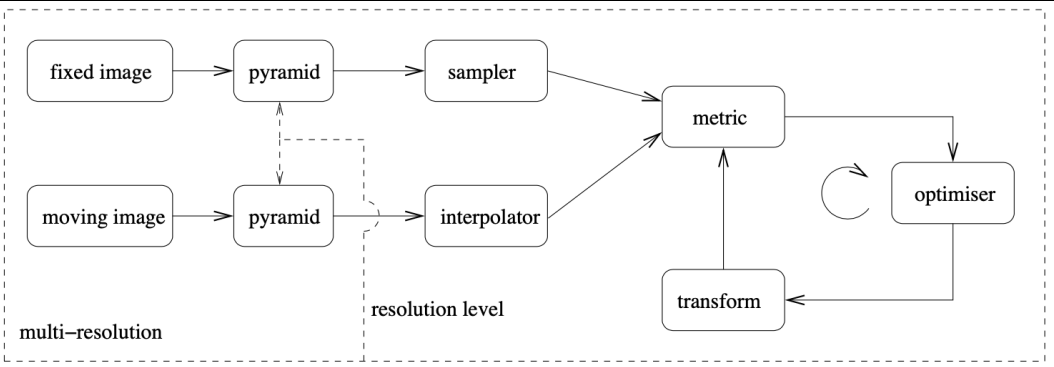


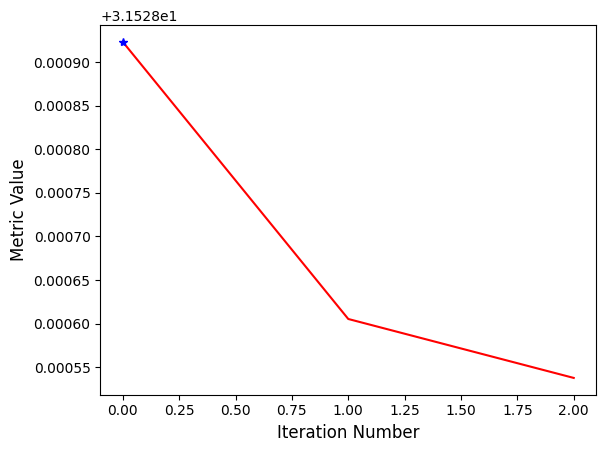

In [18]:
# Set the registration - Fig. 1 from the Theory Note
R = sitk.ImageRegistrationMethod()

# Set a one-level the pyramid scheule. [Pyramid step]
R.SetShrinkFactorsPerLevel(shrinkFactors=[2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the interpolator [Interpolation step]
R.SetInterpolator(sitk.sitkLinear)

# Set the similarity metric [Metric step]
R.SetMetricAsMeanSquares()

# Set the sampling strategy [Sampling step]
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.50)

# Set the optimizer [Optimization step]
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)


# Initialize the transformation type to rigid
initTransform = sitk.Euler3DTransform()
R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to keep track to the optimization process
# R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R)) # Print the iteration number and metric value
R.AddCommand(
    sitk.sitkStartEvent, start_plot
)  # Plot the similarity metric values across iterations
R.AddCommand(sitk.sitkEndEvent, end_plot)
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

# Estimate the registration transformation [metric, optimizer, transform]
tform_reg = R.Execute(vol_sitk, ImgT1_A)

# Apply the estimated transformation to the moving image
ImgT1_B = sitk.Resample(ImgT1_A, tform_reg)

# Save
sitk.WriteImage(ImgT1_B, dir_in + "ImgT1_B.nii")

In [16]:
# estimated transformation
estimated_tform = tform_reg.GetNthTransform(0).GetMatrix()  # Transform matrix

estimated_translation = tform_reg.GetNthTransform(
    0
).GetTranslation()  # Translation vector

params = tform_reg.GetParameters()  # Parameters (Rx, Ry, Rz, Tx, Ty, Tz)

In [24]:
# convert the transformation to a homogeneous matrix
def homogeneous_matrix_from_transform(transform):
    """Convert a SimpleITK transform to a homogeneous matrix."""

    matrix = np.zeros((4, 4))

    matrix[:3, :3] = np.reshape(np.array(transform.GetMatrix()), (3, 3))

    matrix[:3, 3] = transform.GetTranslation()

    matrix[3, 3] = 1

    return matrix


matrix_estimated = homogeneous_matrix_from_transform(tform_reg.GetNthTransform(0))

matrix_applied = homogeneous_matrix_from_transform(transform)

In [25]:
# Store and load the transformation matrix
tform_reg.WriteTransform(dir_in + "A1.tfm")

tform_loaded = sitk.ReadTransform(dir_in + "A1.tfm")

Exercise 7: By default, SimpleITK uses the fixed image’s origin as the rotation center. Change the rotation center to the center of the fixed image and repeat the registration. Compare the results.


In [27]:
# Change the rotation center to the center of the image
initTransform = sitk.CenteredTransformInitializer(
    vol_sitk,
    ImgT1_A,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

## Generate a series of rotated 3D images


Exercise 8: Make four rotation matrices that rotate the ImgT1nii in steps of 60 degrees starting from 60 degrees. Apply the rotation to ImgT1.nii, reslice and store the resulting images as ImgT1_60.nii, ImgT1_120.nii etc. Show in ortho-view that the rotations are applied as expected for each new image.


In [40]:
# Generate four rotation matrices for an image and store them
degrees = [60, 120, 180, 240, 300, 360]


for deg in degrees:
    # Convert degrees to radians for the pitch angle

    pitch_rad = radians(deg)

    # Create an affine transform

    transform = sitk.AffineTransform(3)  # 3D transformation

    # Set the rotation matrix to the affine transform

    transform.SetMatrix(rotation_matrix(pitch_rad, 0, 0).flatten())

    # Apply the transformation to the image

    rotated_image = sitk.Resample(vol_sitk, transform)

    # Save the rotated image

    sitk.WriteImage(rotated_image, f"T1_{deg}" + ".nii")

In [60]:
# Combining a series of affine matrices
# 240 = fixed

# vol_stick = moved

tform_loaded = sitk.ReadTransform(dir_in + file_names[i])


# Load the transforms from file

tform_60 = sitk.ReadTransform(dir_in + file_names[0])

tform_180 = sitk.ReadTransform(dir_in + file_names[1])

tform_240 = sitk.ReadTransform(dir_in + file_names[2])

tform_0 = sitk.ReadTransform(dir_in + "A1.tfm")


# Option A: Combine the transforms using the sitk.CompositeTransform(3) function

# Concatenate - The last added transform is applied first

tform_composite = sitk.CompositeTransform(3)


tform_composite.AddTransform(tform_240.GetNthTransform(0))

tform_composite.AddTransform(tform_180.GetNthTransform(0))

tform_composite.AddTransform(tform_60.GetNthTransform(0))

tform_composite.AddTransform(tform_0.GetNthTransform(0))

# Transform the composite transform to an affine transform

affine_composite = composite2affine(tform_composite)


# Option B: Combine the transforms manually through multiplication of the homogeneous matrices

A = np.eye(4)

for i in range(tform_composite.GetNumberOfTransforms() - 1, -1, -1):
    tform = tform_composite.GetNthTransform(i)

    A_curr = homogeneous_matrix_from_transform(tform)

    A = np.dot(A_curr, A)


tform = sitk.Euler3DTransform()

tform.SetMatrix(A[:3, :3].flatten())

tform.SetTranslation(A[:3, 3])

tform.SetCenter([0, 0, 0])

overlay_slices(Img_fix, Img_mov, title=f"Original (red) vs. ImgT1_{deg} (green)")